In [99]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import gym
import gym_chess
import os
import chess
import glob
from tqdm import tqdm
from gym_chess.alphazero.move_encoding import utils
from pathlib import Path


from typing import Optional

In [100]:
#check if cuda available
torch.cuda.is_available()

True

In [101]:
#helper methods:



#decoding moves from idx to uci notation

def _decodeKnight(action: int) -> Optional[chess.Move]:
    _NUM_TYPES: int = 8

    #: Starting point of knight moves in last dimension of 8 x 8 x 73 action array.
    _TYPE_OFFSET: int = 56

    #: Set of possible directions for a knight move, encoded as 
    #: (delta rank, delta square).
    _DIRECTIONS = utils.IndexedTuple(
        (+2, +1),
        (+1, +2),
        (-1, +2),
        (-2, +1),
        (-2, -1),
        (-1, -2),
        (+1, -2),
        (+2, -1),
    )

    from_rank, from_file, move_type = np.unravel_index(action, (8, 8, 73))

    is_knight_move = (
        _TYPE_OFFSET <= move_type
        and move_type < _TYPE_OFFSET + _NUM_TYPES
    )

    if not is_knight_move:
        return None

    knight_move_type = move_type - _TYPE_OFFSET

    delta_rank, delta_file = _DIRECTIONS[knight_move_type]

    to_rank = from_rank + delta_rank
    to_file = from_file + delta_file

    move = utils.pack(from_rank, from_file, to_rank, to_file)
    return move

def _decodeQueen(action: int) -> Optional[chess.Move]:

    _NUM_TYPES: int = 56 # = 8 directions * 7 squares max. distance

    #: Set of possible directions for a queen move, encoded as 
    #: (delta rank, delta square).
    _DIRECTIONS = utils.IndexedTuple(
        (+1,  0),
        (+1, +1),
        ( 0, +1),
        (-1, +1),
        (-1,  0),
        (-1, -1),
        ( 0, -1),
        (+1, -1),
    )
    from_rank, from_file, move_type = np.unravel_index(action, (8, 8, 73))
    
    is_queen_move = move_type < _NUM_TYPES

    if not is_queen_move:
        return None

    direction_idx, distance_idx = np.unravel_index(
        indices=move_type,
        shape=(8,7)
    )

    direction = _DIRECTIONS[direction_idx]
    distance = distance_idx + 1

    delta_rank = direction[0] * distance
    delta_file = direction[1] * distance

    to_rank = from_rank + delta_rank
    to_file = from_file + delta_file

    move = utils.pack(from_rank, from_file, to_rank, to_file)
    return move

def _decodeUnderPromotion(action):
    _NUM_TYPES: int = 9 # = 3 directions * 3 piece types (see below)

    #: Starting point of underpromotions in last dimension of 8 x 8 x 73 action 
    #: array.
    _TYPE_OFFSET: int = 64

    #: Set of possibel directions for an underpromotion, encoded as file delta.
    _DIRECTIONS = utils.IndexedTuple(
        -1,
        0,
        +1,
    )

    #: Set of possibel piece types for an underpromotion (promoting to a queen
    #: is implicitly encoded by the corresponding queen move).
    _PROMOTIONS = utils.IndexedTuple(
        chess.KNIGHT,
        chess.BISHOP,
        chess.ROOK,
    )

    from_rank, from_file, move_type = np.unravel_index(action, (8, 8, 73))

    is_underpromotion = (
        _TYPE_OFFSET <= move_type
        and move_type < _TYPE_OFFSET + _NUM_TYPES
    )

    if not is_underpromotion:
        return None

    underpromotion_type = move_type - _TYPE_OFFSET

    direction_idx, promotion_idx = np.unravel_index(
        indices=underpromotion_type,
        shape=(3,3)
    )

    direction = _DIRECTIONS[direction_idx]
    promotion = _PROMOTIONS[promotion_idx]

    to_rank = from_rank + 1
    to_file = from_file + direction

    move = utils.pack(from_rank, from_file, to_rank, to_file)
    move.promotion = promotion

    return move

#primary decoding function, the ones above are just helper functions
def decodeMove(action: int, board) -> chess.Move:
        move = _decodeQueen(action)
        is_queen_move = move is not None

        if not move:
            move = _decodeKnight(action)

        if not move:
            move = _decodeUnderPromotion(action)

        if not move:
            raise ValueError(f"{action} is not a valid action")

        # Actions encode moves from the perspective of the current player. If
        # this is the black player, the move must be reoriented.
        turn = board.turn
        
        if turn == False: #black to move
            move = utils.rotate(move)

        # Moving a pawn to the opponent's home rank with a queen move
        # is automatically assumed to be queen underpromotion. However,
        # since queenmoves has no reference to the board and can thus not
        # determine whether the moved piece is a pawn, we have to add this
        # information manually here
        if is_queen_move:
            to_rank = chess.square_rank(move.to_square)
            is_promoting_move = (
                (to_rank == 7 and turn == True) or 
                (to_rank == 0 and turn == False)
            )


            piece = board.piece_at(move.from_square)
            if piece is None: #NOTE I added this, not entirely sure if it's correct
                return None
            is_pawn = piece.piece_type == chess.PAWN

            if is_pawn and is_promoting_move:
                move.promotion = chess.QUEEN

        return move

def encodeBoard(board: chess.Board) -> np.array:
	"""Converts a board to numpy array representation."""

	array = np.zeros((8, 8, 14), dtype=int)

	for square, piece in board.piece_map().items():
		rank, file = chess.square_rank(square), chess.square_file(square)
		piece_type, color = piece.piece_type, piece.color
	
		# The first six planes encode the pieces of the active player, 
		# the following six those of the active player's opponent. Since
		# this class always stores boards oriented towards the white player,
		# White is considered to be the active player here.
		offset = 0 if color == chess.WHITE else 6
		
		# Chess enumerates piece types beginning with one, which we have
		# to account for
		idx = piece_type - 1
	
		array[rank, file, idx + offset] = 1

	# Repetition counters
	array[:, :, 12] = board.is_repetition(2)
	array[:, :, 13] = board.is_repetition(3)

	return array


In [102]:
FRACTION_OF_DATA = 1
BATCH_SIZE = 32

In [103]:
# load dataset

#loading training data

allMoves = []
allBoards = []

files = (glob.glob(r"../data/preparedData/moves*.npy"))

for f in files:
    currUuid = f.split("moves")[-1].split(".npy")[0]
    try:
        moves = np.load(f"../data/preparedData/moves{currUuid}.npy", allow_pickle=True)
        boards = np.load(f"../data/preparedData/positions{currUuid}.npy", allow_pickle=True)
        if (len(moves) != len(boards)):
            print("ERROR ON i = ", currUuid, len(moves), len(boards))
        allMoves.extend(moves)
        allBoards.extend(boards)
    except:
        print("error: could not load ", currUuid, ", but is still going")
        pass
        

allMoves = np.array(allMoves)[:(int(len(allMoves) * FRACTION_OF_DATA))]
allBoards = np.array(allBoards)[:(int(len(allBoards) * FRACTION_OF_DATA))]
assert len(allMoves) == len(allBoards), "MUST BE OF SAME LENGTH"


#flatten out boards
# allBoards = allBoards.reshape(allBoards.shape[0], -1)

trainDataIdx = int(len(allMoves) * 0.8)

#NOTE transfer all data to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
allBoards = torch.from_numpy(np.asarray(allBoards)).to(device)
allMoves = torch.from_numpy(np.asarray(allMoves)).to(device)

training_set = torch.utils.data.TensorDataset(allBoards[:trainDataIdx], allMoves[:trainDataIdx])
test_set = torch.utils.data.TensorDataset(allBoards[trainDataIdx:], allMoves[trainDataIdx:])
# Create data loaders for our datasets; shuffle for training, not for validation

training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"loaded {len(allMoves)} moves and positions")


loaded 343054 moves and positions


Remember:

board shape: (batch shape, 896)

can check turn with "board.turn" -> true means white to move, false mean black to move

4672 potential moves (so can encode from 0 -> 4671 inclusive)

In [104]:
#model
class Model(torch.nn.Module):
    

    def __init__(self):
        super(Model, self).__init__()
        self.INPUT_SIZE = 896 
        # self.INPUT_SIZE = 7*7*13 #NOTE changing input size for using cnns
        self.OUTPUT_SIZE = 4672 # = number of unique moves (action space)
        
		#can try to add CNN and pooling here (calculations taking into account spacial features)

        #input shape for sample is (8,8,14), flattened to 1d array of size 896
        # self.cnn1 = nn.Conv3d(4,4,(2,2,4), padding=(0,0,1))

        self.activation = torch.nn.Tanh()   
        # self.activation = torch.nn.ReLU()

        self.linear1 = torch.nn.Linear(self.INPUT_SIZE, 1000)
        self.linear2 = torch.nn.Linear(1000, 1000)
        self.linear3 = torch.nn.Linear(1000, 1000)
        self.linear4 = torch.nn.Linear(1000, 200)
        self.linear5 = torch.nn.Linear(200, self.OUTPUT_SIZE)
        self.softmax = torch.nn.Softmax(1) #use softmax as prob for each move, dim 1 as dim 0 is the batch dimension
 
    def forward(self, x): #x.shape = (batch size, 896)
        x = x.to(torch.float32)
        # x = self.cnn1(x) #for using cnns
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)
        x = self.activation(x)
        x = self.linear5(x)
        # x = self.softmax(x) #do not use softmax since you are using cross entropy loss
        return x

    def predict(self, board : chess.Board):
        """takes in a chess board and returns a chess.move object. NOTE: this function should definitely be written better, but it works for now"""
        with torch.no_grad():
            encodedBoard = encodeBoard(board)
            encodedBoard = encodedBoard.reshape(1, -1)
            encodedBoard = torch.from_numpy(encodedBoard)
            res = self.forward(encodedBoard)
            probs = self.softmax(res)

            probs = probs.numpy()[0] #do not want tensor anymore, 0 since it is a 2d array with 1 row

            #verify that move is legal and can be decoded before returning
            while len(probs) > 0: #try max 100 times, if not throw an error
                moveIdx = probs.argmax()
                try: #TODO should not have try here, but was a bug with idx 499 if it is black to move
                    uciMove = decodeMove(moveIdx, board)
                    if (uciMove is None): #could not decode
                        probs = np.delete(probs, moveIdx)
                        continue
                    move = chess.Move.from_uci(str(uciMove))
                    if (move in board.legal_moves): #if legal, return, else: loop continues after deleting the move
                        return move 
                except:
                    pass
                probs = np.delete(probs, moveIdx) #TODO probably better way to do this, but it is not too time critical as it is only for predictions
                                             #remove the move so its not chosen again next iteration
            
            #return random move if model failed to find move
            moves = board.legal_moves
            if (len(moves) > 0):
                return np.random.choice(list(moves))
            print("Your predict function could not find any legal/decodable moves")
            return None #if no legal moves found, return None
            # raise Exception("Your predict function could not find any legal/decodable moves")





In [105]:
#helper functions for training
def train_one_epoch(model, optimizer, loss_fn, epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):

        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            # print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss


def createBestModelFile():
    #first find best model if it exists:
    path = Path('../data/savedModels/bestModel.txt')

    if not (path.is_file()):
        #create the files
        f = open(path, "w")
        f.write("10000000") #set to high number so it is overwritten with better loss
        f.write("\ntestPath")
        f.close()

def saveBestModel(vloss, pathToBestModel):
    f = open("../data/savedModels/bestModel.txt", "w")
    f.write(str(vloss.item()))
    f.write("\n")
    f.write(pathToBestModel)
    print("NEW BEST MODEL FOUND WITH LOSS:", vloss)

def retrieveBestModelInfo():
    f = open('../data/savedModels/bestModel.txt', "r")
    bestLoss = float(f.readline())
    bestModelPath = f.readline()
    f.close()
    return bestLoss, bestModelPath



In [135]:
#hyperparams
EPOCHS = 500
LEARNING_RATE = 0.001
MOMENTUM = 0.9

In [114]:
#TODO implement early stop if no improvement is not seen for a while

In [115]:
#run training


createBestModelFile()

bestLoss, bestModelPath = retrieveBestModelInfo()


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

model = Model()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

best_vloss = 1_000_000.

for epoch in tqdm(range(EPOCHS)):
    if (epoch_number % 5 == 0):
        print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(model, optimizer, loss_fn, epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.

    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)

            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)

    #only print every 5 epochs
    if epoch_number % 5 == 0:
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

        if (bestLoss > best_vloss): #if better than previous best loss from all models created, save it
            model_path = '../data/savedModels/model_{}_{}'.format(timestamp, epoch_number)
            torch.save(model.state_dict(), model_path)
            saveBestModel(best_vloss, model_path)



    epoch_number += 1

# print("\n\nBEST VALIDATION LOSS FOR ALL MODELS: ", bestLoss)

  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 0/500 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [116]:
#load best model
saved_model = Model()

#load best model path from your file
f = open("../data/savedModels/bestModel.txt", "r")
bestLoss = float(f.readline())
model_path = f.readline()
f.close()

saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Autoplay game against stockfish

In [117]:
# test elo  against stockfish
ELO_RATING = 100
from stockfish import Stockfish
stockfish = Stockfish(path=r"../stockfish/stockfish-windows-x86-64-avx2.exe")

stockfish.set_elo_rating(ELO_RATING)
stockfish.set_skill_level(0)




  8%|▊         | 12/150 [00:00<00:02, 59.27it/s]

game over. You lost in 21 moves


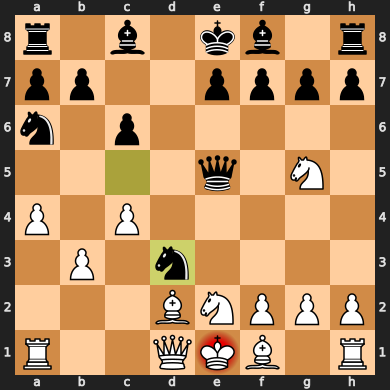

In [134]:
board = chess.Board()
allMoves = [] #list of strings for saving moves for setting pos for stockfish

MAX_NUMBER_OF_MOVES = 150
for i in tqdm(range(MAX_NUMBER_OF_MOVES)): #set a limit for the game
	#first my ai move
	try:
		move = saved_model.predict(board)
		board.push(move)
		allMoves.append(str(move)) #add so stockfish can see
	except Exception as e:
		if str(e) == "object of type 'LegalMoveGenerator' has no len()":
			print("game over. You lost in", i, "moves")
		else:
			print("An error occurred:", str(e))
		break
	# #then get stockfish move
	stockfish.set_position(allMoves)
	stockfishMove = stockfish.get_best_move_time(1)
	allMoves.append(stockfishMove)
	stockfishMove = chess.Move.from_uci(stockfishMove)
	board.push(stockfishMove)


board

In [128]:
#play 1 move at a time against stockfish
board = chess.Board()
stockfish.set_position([])
stockfish.set_skill_level(0)
allMoves = [] #list of strings for saving moves for setting pos for stockfish

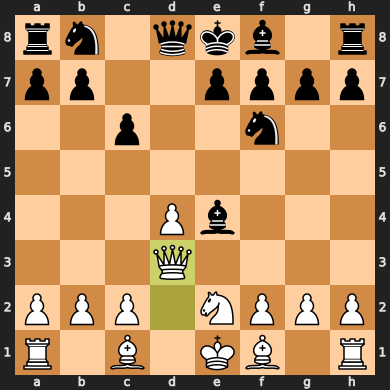

In [97]:

try:
    move = saved_model.predict(board)
    board.push(move)
    allMoves.append(str(move)) #add so stockfish can see
except:
    print("game over. You lost")
board

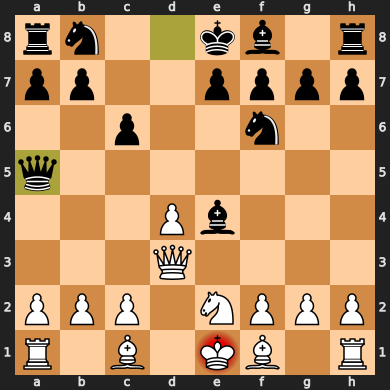

In [98]:
stockfish.set_position(allMoves)
stockfishMove = stockfish.get_best_move_time(1)
allMoves.append(stockfishMove)
stockfishMove = chess.Move.from_uci(stockfishMove)
board.push(stockfishMove)
board

In [124]:
stockfish.reset_engine_parameters() #reset elo rating

In [28]:
print(saved_model.predict(board))

In [67]:
stockfish.set_position([])

In [68]:
#play your own game
board = chess.Board()

In [69]:
#regret move:
board.pop()

In [70]:
#make my move:
moveStr = "e2e4"
move = chess.Move.from_uci(moveStr)
board.push(move)

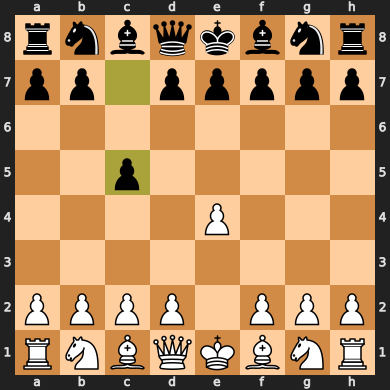

In [71]:
#make ai move:
aiMove = saved_model.predict(board)
board.push(aiMove)
board

In [ ]:
#try to play game against old model